# Identifying Faces In A Single Movie

### By Wanga Mulaudzi
---
This notebook analyses 1k screengrabs from a single movie that is part of the cine_ethics dataset and identifies faces.

## Import statements

In [57]:
import cv2
from google.cloud import storage
import io
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

## Loading the data
The data is in a bucket on google cloud so we can load the data into the notebook. First, we need to authorize the notebook to access the project.

In [5]:
!gcloud auth login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=Tz1PxeeRXkga8VuLQpRHRwSVdXzkRU&access_type=offline&code_challenge=R97Qn_c2nD9oHM5jVRb2eQmPOpR71Tv10v_R0HSxYyQ&code_challenge_method=S256


You are now logged in as [w.m.mulaudzi@gmail.com].
Your current project is [ornate-lens-411311].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update



In [7]:
# Log into the cine_ethics project
project_id = "ornate-lens-411311"
client = storage.Client(project=project_id)

bucket_name = "cine_ethics"
bucket = client.get_bucket(bucket_name)

In [60]:
# Load pre-trained Haar cascade classifier for face detection
haarcascade_path = "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + haarcascade_path)

In [62]:
# Name of the movie to analyse
movie = "Her (2013)"

# Path to the movie on the bucket
ai_movies_path = "data/resized_frames/" + movie

# Get blobs within the movie folder
blobs = bucket.list_blobs(prefix=ai_movies_path)

# Store the image path names
image_paths = []
image_arrays = []

for blob in blobs:
    # Append image path
    image_paths.append(blob.name)

    # Download the image as bytes
    img_bytes = blob.download_as_bytes()

    # Open the image
    img = Image.open(io.BytesIO(img_bytes))

    # Convert image to an array
    img = np.array(img)

    # Append array image to list
    image_arrays.append(img)

    # Convert image to grayscale (required for Haar cascades)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Draw rectangles around the detected faces
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Visualize results
    cv2.imshow('Detected Faces', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    break

In [37]:
# Convert the list of images to a numpy array
image_arrays = np.array(image_arrays)

In [38]:
# Shape of one image
img_shape = image_arrays[0].shape
img_shape

(256, 476, 3)

## KMeans Clustering
Now we need to perform unsupervised learning on the images to extract features.

### Preprocessing

In [31]:
def preprocess_image(image):
    """Returns a preprocessed image.

    Parameters:
        image: A RGB image with pixel values in range [0, 255].
    Returns
        image: The preprocessed image.
    """
    image = image / 255.

    return image

In [39]:
preprocessed_images = preprocess_image(image_arrays)

### Define the model

In [32]:
# Load pre-trained Haar cascade classifier for face detection
haarcascade_path = "/Users/wangamulaudzi/code/wangamulaudzi/cine_ethics/raw_data/haarcascade_model/haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + haarcascade_path)

# Load input image
image = cv2.imread('input_image.jpg')

# Convert image to grayscale (required for Haar cascades)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the grayscale image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Draw rectangles around the detected faces
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

# Visualize results
cv2.imshow('Detected Faces', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [33]:
input_layer = tf.keras.Input(shape=img_shape, name='input_image')

In [34]:
model = cnn_model(input_layer)

58889256/58889256 [==============================] - 6s 0us/step


In [40]:
# Predict the features
features = model.predict(preprocessed_images)

# Flatten the features
features = features.reshape(features.shape[0], -1)

32/32 [==============================] - 1293s 40s/step


In [54]:
# Apply K-Means clustering
num_clusters = 5  # Photo either has a person in it or not

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(features)

KMeans(n_clusters=5, random_state=42)

In [55]:
# Get cluster labels
cluster_labels = kmeans.labels_

Cluster 0: 1 images


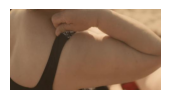

Cluster 1: 511 images


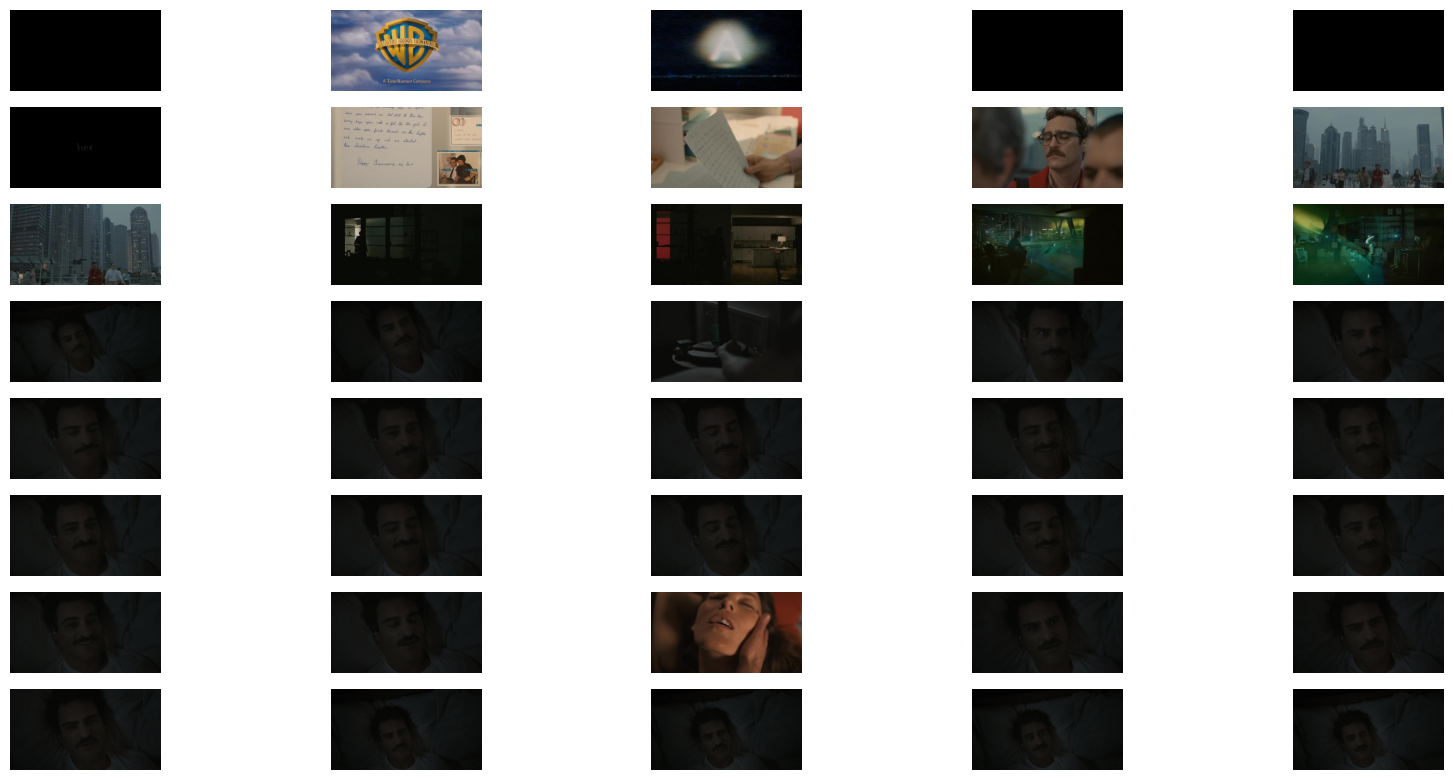

Cluster 2: 420 images


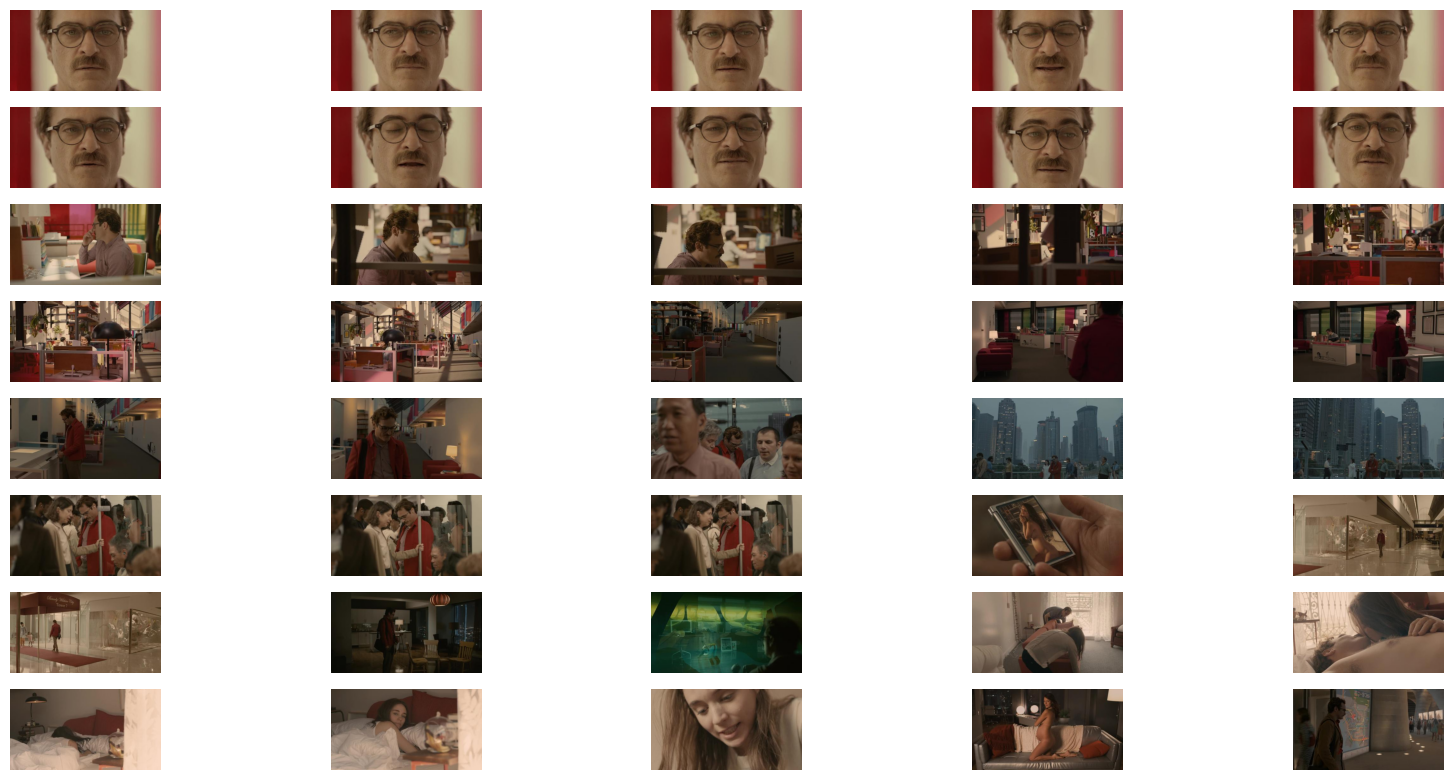

Cluster 3: 25 images


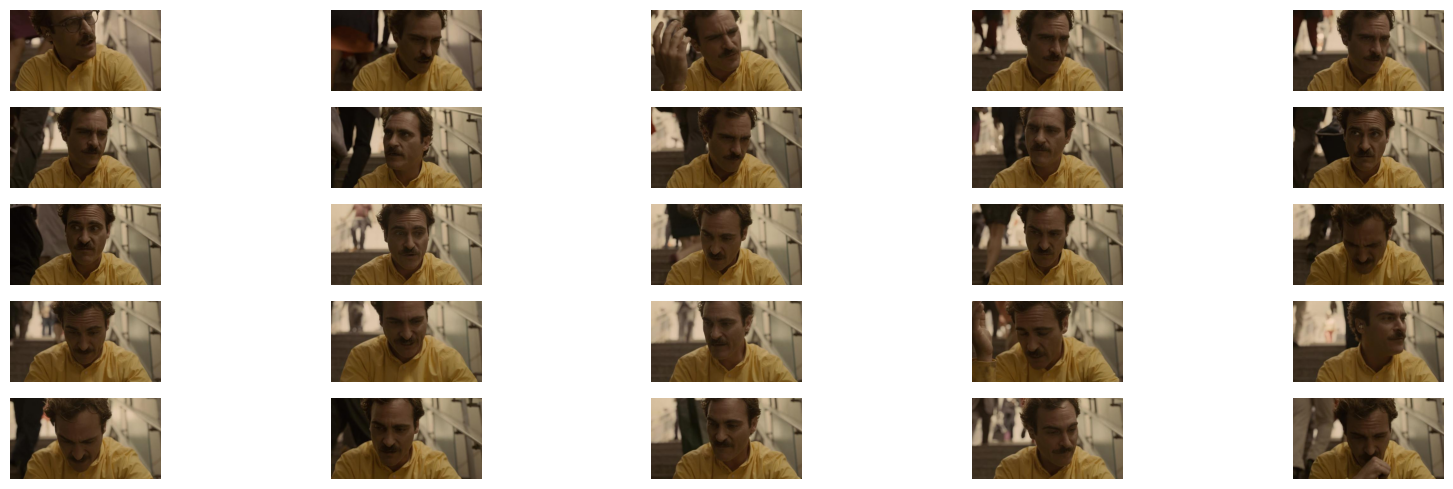

Cluster 4: 43 images


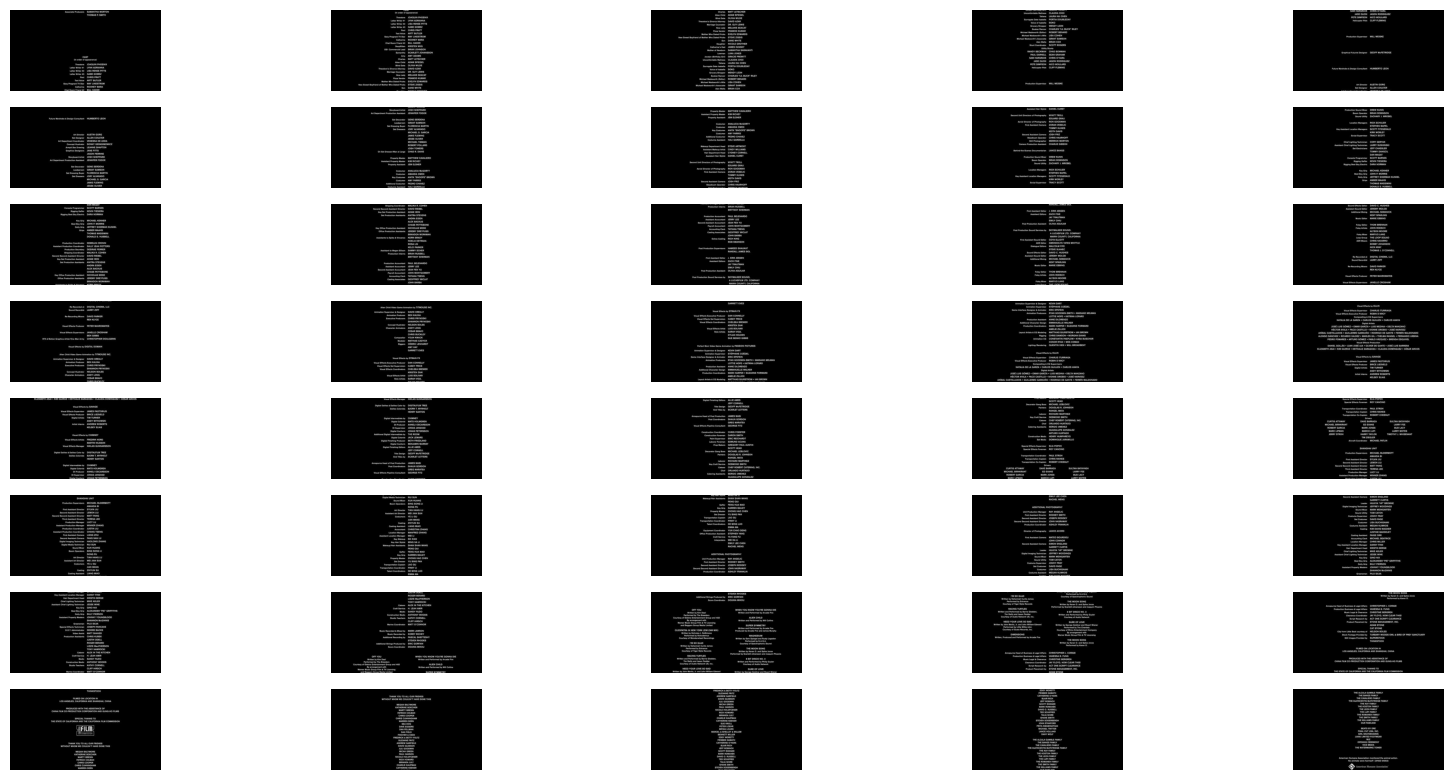

In [56]:
# Plot images from each cluster
for cluster_id in range(num_clusters):

    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    print(f"Cluster {cluster_id}: {len(cluster_indices)} images")

    plt.figure(figsize=(20, 25))
    for i, idx in enumerate(cluster_indices[:40]):  # Plot only first 10 images from each cluster
        plt.subplot(20, 5, i + 1)
        plt.imshow(image_arrays[idx])
        plt.axis('off')
    plt.show()